## Cabinet Sandbox - Youtube thumbnails Example
#### Description
Cabinet sandbox exists to provide an example of the Cabinet system at work. In this example (youtube.py), a dataset of thumbnail images and their assoicated metadata are uploaded to Cabinet. The other functions in the cabinet_sdk library are then demonstrated using the uploaded data
#### The Data
A file system containing youtube video thumnbnails and a csv with associated metadata.

Link to dataset: https://www.kaggle.com/datasets/praneshmukhopadhyay/youtube-thumbnail-dataset 

In [22]:
%load_ext autoreload 
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
from typing import List
from PIL import Image 
import io
from IPython import display
from base64 import b64decode, b64encode
import pdb
import cabinet_sdk as c

Test cabinet_sdk library is installed and working 


In [41]:
c.welcome('John Smith')

Welcome John Smith to Cabinet


##### PROCESS DATA INTO FORMAT THAT CAN BE UPLOADED TO CABINET 
note: this is specific to this data set (youtube thumbnails) 



1. Turn csv metadata into List[dicts] 


In [42]:
desired_num_entries = 2

def create_metadata_list() -> list:
    with open('mini_metadata.csv',newline='') as csvfile:
        count = 0
        metadata = [] 
        while True and count < (desired_num_entries+1):
            entry_line= csvfile.readline()
            if not entry_line:
                break
            entry_list= entry_line.strip().split(',')
            # if title split because it contianed commas, recreate single title
            if len(entry_list) > 4:
                title_split = entry_list[3:]
                title = ', '.join(title_split) 
                entry_list[3] = title 
            entry_metadata = {'blob_type':'youtube','photo_id': entry_list[0], 'channel':entry_list[1],'category':entry_list[2],'title':entry_list[3]}
            metadata.append(entry_metadata)
            count += 1
    return metadata[1:]

metadatas = create_metadata_list()
print(metadatas)


[{'blob_type': 'youtube', 'photo_id': 'OkmNXy7er84', 'channel': '3Blue1Brown', 'category': 'Science', 'title': 'The hardest problem on the hardest test'}, {'blob_type': 'youtube', 'photo_id': 'r6sGWTCMz2k', 'channel': '3Blue1Brown', 'category': 'Science', 'title': 'But what is a Fourier series? From heat flow to drawing with circles | DE4'}]


2. Use metadata info to generate list of file_paths to corresponding thumbnail

In [43]:
def create_paths_list(md) -> list:
    paths = []
    for i in md:
        channel = i['channel']
        id = i['photo_id']
        path = 'images/'+f'{channel}/'+f'{id}.jpg'
        paths.append(path)
    return paths
    
paths = create_paths_list(metadatas) 
print(paths)

['images/3Blue1Brown/OkmNXy7er84.jpg', 'images/3Blue1Brown/r6sGWTCMz2k.jpg']


3. Create a list of tuples with t[0]=metadata:dict, t[1]=img_file_path:str

In [44]:
def create_upload_tuples(metadatas:list, paths:list) -> list: 
    upload_tups = []
    for i in range(len(paths)):
        upload_tups.append((metadatas[i],paths[i]))
    return upload_tups

blob_info:List[tuple] = create_upload_tuples(metadatas,paths)
print(blob_info)

[({'blob_type': 'youtube', 'photo_id': 'OkmNXy7er84', 'channel': '3Blue1Brown', 'category': 'Science', 'title': 'The hardest problem on the hardest test'}, 'images/3Blue1Brown/OkmNXy7er84.jpg'), ({'blob_type': 'youtube', 'photo_id': 'r6sGWTCMz2k', 'channel': '3Blue1Brown', 'category': 'Science', 'title': 'But what is a Fourier series? From heat flow to drawing with circles | DE4'}, 'images/3Blue1Brown/r6sGWTCMz2k.jpg')]


### Cabinet at Work

BLOB_TYPES - provieds name and metadata fields for all blob_types in your Cabinet

In [45]:
print(c.blob_types())

{'fruit': ['entry_id', 'blob_type', 'fruit_name', 'fruit_color', 'blob_id'], 'chess': ['entry_id', 'blob_type'], 'youtube': ['entry_id', 'blob_type', 'blob_id', 'photo_id', 'channel', 'category', 'title']}


FIELDS - lists metadata fields of specified blob_type

In [46]:
print(c.fields('youtube'))

['entry_id', 'blob_type', 'blob_id', 'photo_id', 'channel', 'category', 'title']


#### Upload Blobs
Iterate through list of tuples and add each blob+metadata to Cabinet using the cabinet UPLOAD function 

In [47]:
def upload_bulk_data(blob_info:List[tuple]):
    for tup in blob_info:
        try:  
            print(c.upload(tup[0], tup[1]))
        except Exception as e: 
            print(e.args[0])
            continue

upload_bulk_data(blob_info) 

{'entry_id': 36}
{'entry_id': 37}


SEARCH - search for entries that match specified metadata values. You can use any number of valid metadata fields to search. 

In [48]:
preview = 1

matching_entries = c.search('youtube',{'category':'Science'})
for key in matching_entries:
    print(key, matching_entries[key][:preview])

entry_id [36]
blob_type ['youtube']
blob_id ['47a93b4aa1015bc349bb094a003fc61be47fcce37641e9a231114762ad566f57']
photo_id ['OkmNXy7er84']
channel ['3Blue1Brown']
category ['Science']
title ['The hardest problem on the hardest test']


If no metadata values are provided, all entries for specified blob_type are returned 

In [49]:
matching_entries = c.search('youtube')
num_entries = len(matching_entries['entry_id'])
print(f'There are {num_entries} youtube entries')


There are 2 youtube entries


UPDATE - creates a soft update 

In [55]:
# Pre-update: search all entries in youtube table matching specified title
resp = c.search('youtube',{'title':'The hardest problem on the hardest test'})
print(resp)
entry_id_ex = resp['entry_id'][0]

{'entry_id': [36, 38], 'blob_type': ['youtube', 'youtube'], 'blob_id': ['47a93b4aa1015bc349bb094a003fc61be47fcce37641e9a231114762ad566f57', '47a93b4aa1015bc349bb094a003fc61be47fcce37641e9a231114762ad566f57'], 'photo_id': ['OkmNXy7er84', 'OkmNXy7er84'], 'channel': ['3Blue1Brown', '3Blue1Brown'], 'category': ['Science', 'MATH'], 'title': ['The hardest problem on the hardest test', 'The hardest problem on the hardest test']}


In [52]:
# Update: a new metadata entry containing the specified changes is added to the youtube table 
id_of_update = c.update('youtube',entry_id_ex,{'category':'MATH'})
print(id_of_update)

{'entry_id': 38}


In [53]:
# After update rerun search
print(c.search('youtube',{'title':'The hardest problem on the hardest test'}))

{'entry_id': [36, 38], 'blob_type': ['youtube', 'youtube'], 'blob_id': ['47a93b4aa1015bc349bb094a003fc61be47fcce37641e9a231114762ad566f57', '47a93b4aa1015bc349bb094a003fc61be47fcce37641e9a231114762ad566f57'], 'photo_id': ['OkmNXy7er84', 'OkmNXy7er84'], 'channel': ['3Blue1Brown', '3Blue1Brown'], 'category': ['Science', 'MATH'], 'title': ['The hardest problem on the hardest test', 'The hardest problem on the hardest test']}


RETRIEVE - returns desired blob in bytes

In [56]:
blob_in_bytes = c.retrieve('youtube', entry_id_ex)
print('First 20 characters of blob in bytes: ', blob_in_bytes[:20])


First 20 characters of blob in bytes:  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00'


### Post Processing
blob must be further processed by user to regain original format

In [37]:
# opens image in new window
Image.open(io.BytesIO(blob_in_bytes)).show()

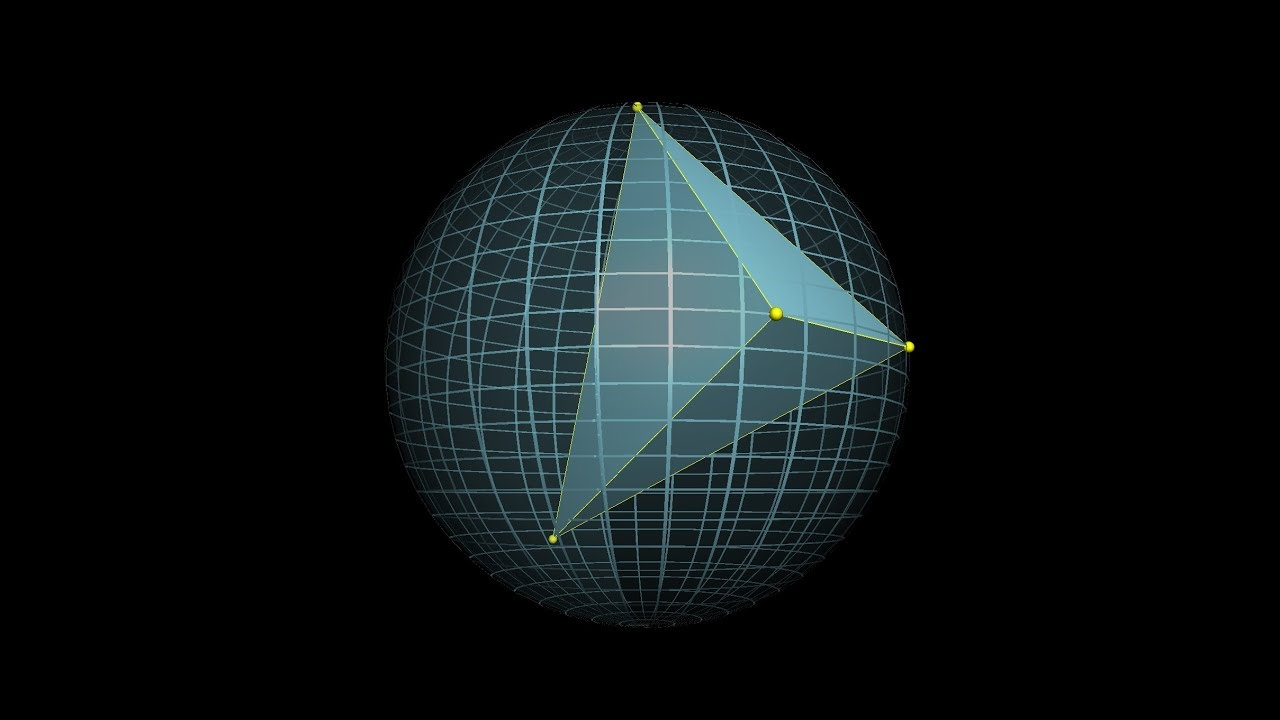

In [57]:
# display img in notebook 
blob_base64 = b64encode(blob_in_bytes)
display.Image(b64decode(blob_base64))